In [1]:
import argparse
import logging
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch
import sys
# The path you want to add  
path_to_add = r'/home/etaylor/code_projects/dubby'  
# Add the directory to sys.path  
sys.path.insert(0, path_to_add)
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
def validate_cuda():
    if torch.cuda.is_available():
        logger.info("CUDA is available. 🚀")
        logger.info(f"CUDA version: {torch.version.cuda}")
        try:
            logger.info(f"GPU Name: {torch.cuda.get_device_name(0)}")
        except AssertionError as e:
            logger.error("Failed to get the GPU name. Ensure a GPU device is properly installed.")
            sys.exit(1)  # Exiting the process if no GPU device is found
    else:
        logger.error("CUDA is not available. Please check your installation.")
        sys.exit(1)  # Exiting the process if CUDA is not available

validate_cuda()

2024-03-21 12:15:07,019 - INFO - CUDA is available. 🚀
2024-03-21 12:15:07,020 - INFO - CUDA version: 11.8
2024-03-21 12:15:07,023 - INFO - GPU Name: NVIDIA TITAN RTX


In [2]:
from src.classification.hg_classification.hg_classification_pipe import train_and_evaluate
import src.constants as const

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # for generative models likt T5 use this code
    # predictions = np.argmax(logits[0], axis=-1)
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [6]:
model_name = "distilbert-base-uncased"
tokenizer_name = model_name
output_dir = "/home/etaylor/code_projects/dubby/results/classification/title_post_comment"
train_dataset_path = "/home/etaylor/code_projects/dubby/data/updated_data/train_title_comment_balanced.csv"
test_dataset_path = "/home/etaylor/code_projects/dubby/data/updated_data/test_title_comment_balanced.csv"
print(f"Training model: {model_name}")
logger.info(f"Loading training dataset from: {train_dataset_path}")
train_dataset = load_dataset('csv', data_files=train_dataset_path)['train']
logger.info(f"Loading test dataset from: {test_dataset_path}")
test_dataset = load_dataset('csv', data_files=test_dataset_path)['train']
datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})
logger.info("Datasets loaded successfully.")

logger.info(f"Initializing tokenizer: {tokenizer_name}")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
# tokenizer.pad_token = tokenizer.eos_token
logger.info("Tokenizer initialized.")

logger.info("Tokenizing datasets...")
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)
tokenized_datasets = datasets.map(tokenize_function, batched=True)
logger.info("Datasets tokenized.")

logger.info(f"Initializing model: {model_name}")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
logger.info("Model initialized.")

logger.info("Setting up training arguments...")
# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=5e-3,  # Adjusted learning rate
    per_device_train_batch_size=16,  # Adjusted batch size
    per_device_eval_batch_size=16,  # Adjusted batch size
    num_train_epochs=4,  # Adjusted number of epochs
    weight_decay=0.001,
    save_strategy="epoch",
    load_best_model_at_end=True,
)
logger.info("Training arguments set.")

logger.info("Initializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
logger.info("Trainer initialized.")

logger.info("Starting training...")
trainer.train()
logger.info("Training completed.")

2024-03-21 13:59:26,164 - INFO - Loading training dataset from: /home/etaylor/code_projects/dubby/data/updated_data/train_title_comment_balanced.csv


Training model: distilbert-base-uncased


Generating train split: 0 examples [00:00, ? examples/s]

2024-03-21 13:59:27,538 - INFO - Loading test dataset from: /home/etaylor/code_projects/dubby/data/updated_data/test_title_comment_balanced.csv


Generating train split: 0 examples [00:00, ? examples/s]

2024-03-21 13:59:28,423 - INFO - Datasets loaded successfully.
2024-03-21 13:59:28,424 - INFO - Initializing tokenizer: distilbert-base-uncased
2024-03-21 13:59:28,814 - INFO - Tokenizer initialized.
2024-03-21 13:59:28,815 - INFO - Tokenizing datasets...


Map:   0%|          | 0/11782 [00:00<?, ? examples/s]

Map:   0%|          | 0/2806 [00:00<?, ? examples/s]

2024-03-21 13:59:34,561 - INFO - Datasets tokenized.
2024-03-21 13:59:34,562 - INFO - Initializing model: distilbert-base-uncased
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-03-21 13:59:35,048 - INFO - Model initialized.
2024-03-21 13:59:35,048 - INFO - Setting up training arguments...
2024-03-21 13:59:35,051 - INFO - Training arguments set.
2024-03-21 13:59:35,051 - INFO - Initializing Trainer...
2024-03-21 13:59:35,054 - WARNING - Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
2024-03-21 13:59:35,157 - INFO - Trainer initialized.
2024

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.587800,0.567486,0.677477,0.623387,0.749000,0.533856
2,0.556200,0.593711,0.677833,0.619529,0.756423,0.524590
3,0.435500,0.710917,0.654669,0.619253,0.690018,0.561654
4,0.307500,1.089757,0.654312,0.614774,0.694170,0.551675


2024-03-21 14:15:20,878 - INFO - Training completed.


In [ ]:
checkpoint_output_dir = "/home/etaylor/code_projects/dubby/results/last_model_roberta_checkpoint"


In [ ]:
trainer.save_model(checkpoint_output_dir)  # Save the model to the specified output directory

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Assuming 'output_dir' is where your fine-tuned model is saved
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_output_dir)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_output_dir)


In [ ]:
import pandas as pd
test_dataset_path = "/home/etaylor/code_projects/dubby/data/updated_data/test_title_post_comment_father_comment.csv"

test_df = pd.read_csv(test_dataset_path)
test_df.head()

,text,label
0,title: CMV: Anything that is man-made is natur...,1
1,title: CMV: Anything that is man-made is natur...,1
2,title: CMV: Anything that is man-made is natur...,1
3,title: CMV: Anything that is man-made is natur...,0
4,title: CMV: Veganism and vegetarianism are not...,1


In [ ]:
train_dataset_path = "/home/etaylor/code_projects/dubby/data/updated_data/train_title_post_comment_father_comment.csv"
train_df = pd.read_csv(train_dataset_path)
train_df.head()

,text,label
0,title: CMV:Essential Oils are bullshit [SEP] p...,1
1,title: CMV:Essential Oils are bullshit [SEP] p...,1
2,title: CMV:Essential Oils are bullshit [SEP] p...,0
3,title: CMV:Essential Oils are bullshit [SEP] p...,0
4,title: CMV: I think the Paris shooting makes a...,0


In [ ]:
from pprint import pprint
pprint(train_df['text'][0])

('title: CMV:Essential Oils are bullshit [SEP] post: My wife has recently '
 'gotten deeply involved/obsessed with the healing properties of essential '
 'oils.  I am cursed with a common problem in that I am an extremely skeptical '
 "person.  I can't help but look at this product and see a pyramid scheme that "
 'takes advantage of the gullible.  All the shit my wife watches on these oils '
 "is carefully worded to make sure they don't make actual healing claims, I'm "
 "told this is because they aren't FDA approved and could get in trouble.  "
 "I've looked a little and haven't found anything debunking these oils but i "
 'still cannot help but feel they are total BS.  I would love to get more '
 'information from unbiased sources on this.  \n'
 '\n'
 'Please change my view without just anecdotal testimonies.  [SEP] comment: '
 '[This answer in /r/askscience does a pretty good job of describing essential '
 'oils.](http://www.reddit.com/r/askscience/comments/2pp57r/how_effective_are

In [ ]:
texts = test_df["text"].tolist()

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

In [ ]:
texts = test_df["text"].tolist()

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Predict
with torch.no_grad():
    logits = model(**inputs).logits

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)

# Assuming you want the index of the highest probability as the label
predictions = torch.argmax(probabilities, dim=1)

# Add the predictions to your DataFrame
test_df["model_label"] = predictions.numpy()

# Add the probability for label "1"
# This step assumes binary classification or that you're specifically interested in label "1" in multi-class.
# Adjust the index [1] if your label of interest is different.
test_df["model_prob"] = probabilities[:, 1].numpy()

In [ ]:
test_df.head()

,text,label,model_label,model_prob
0,title: CMV: Anything that is man-made is natur...,1,1,0.629523
1,title: CMV: Anything that is man-made is natur...,1,1,0.629527
2,title: CMV: Anything that is man-made is natur...,1,1,0.629521
3,title: CMV: Anything that is man-made is natur...,0,1,0.629523
4,title: CMV: Veganism and vegetarianism are not...,1,1,0.629530


In [ ]:
test_df['label'].value_counts() / len(test_df)

label
1    0.6326
0    0.3674
Name: count, dtype: float64

In [ ]:
# Count how many 0s in the model_label column
test_df["model_label"] == 0


0       False
1       False
2       False
3       False
4       False
        ...  
3811    False
3812    False
3813    False
3814    False
3815    False
Name: model_label, Length: 3816, dtype: bool

In [ ]:
import pandas as pd
df = pd.read_csv("/home/etaylor/code_projects/dubby/results/generation/gpt-4-32k/no_article_insights/test_comment_results.csv")

In [ ]:
import os
import pandas as pd


# Assuming model and tokenizer are already defined and loaded
model.eval()  # Ensure the model is in evaluation mode

def add_inference_columns(csv_path, save_path):
    df = pd.read_csv(csv_path)
    
    # Tokenize and perform inference on 'generated_comment'
    tokens_gen_comment = tokenizer(df['generated_comment'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs_gen_comment = model(**tokens_gen_comment)
        predictions_gen_comment = outputs_gen_comment.logits.argmax(-1).numpy()
        probabilities_gen_comment = outputs_gen_comment.logits.softmax(-1).max(dim=1).values.numpy()
    
    # Tokenize and perform inference on 'text'
    tokens_text = tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs_text = model(**tokens_text)
        predictions_text = outputs_text.logits.argmax(-1).numpy()
        probabilities_text = outputs_text.logits.softmax(-1).max(dim=1).values.numpy()
    
    # Add new columns for predictions and probabilities for both 'text' and 'generated_comment'
    df['predicted_label_gen_comment'] = predictions_gen_comment
    df['prediction_probability_gen_comment'] = probabilities_gen_comment
    df['predicted_label_text'] = predictions_text
    df['prediction_probability_text'] = probabilities_text
    
    # Ensure the save path directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the modified DataFrame to CSV
    df.to_csv(save_path, index=False)

# Define source and target directories
source_directory = "/home/etaylor/code_projects/dubby/results/generation"
target_directory = "/home/etaylor/code_projects/dubby/results/generation_conversion"

# Walk through the source directory to process and save modified CSV files in the target directory
for root, dirs, files in os.walk(source_directory):
    for file in files:
        if file.endswith('.csv'):
            csv_path = os.path.join(root, file)
            relative_path = os.path.relpath(csv_path, source_directory)
            save_path = os.path.join(target_directory, relative_path)
            add_inference_columns(csv_path, save_path)
            print(f"Processed and saved: {save_path}")


Processed and saved: /home/etaylor/code_projects/dubby/results/generation_conversion/gpt-35-turbo/no_article_insights/test_comment_results.csv
Processed and saved: /home/etaylor/code_projects/dubby/results/generation_conversion/gpt-35-turbo/no_article_insights/test_title_comment_results.csv
Processed and saved: /home/etaylor/code_projects/dubby/results/generation_conversion/gpt-35-turbo/no_article_insights/test_title_post_comment_father_comment_results.csv
Processed and saved: /home/etaylor/code_projects/dubby/results/generation_conversion/gpt-35-turbo/no_article_insights/test_title_post_comment_results.csv
Processed and saved: /home/etaylor/code_projects/dubby/results/generation_conversion/gpt-35-turbo/with_article_insights/test_comment_results.csv
Processed and saved: /home/etaylor/code_projects/dubby/results/generation_conversion/gpt-35-turbo/with_article_insights/test_title_comment_results.csv
Processed and saved: /home/etaylor/code_projects/dubby/results/generation_conversion/gpt-

In [ ]:
df2 = pd.read_csv("/home/etaylor/code_projects/dubby/results/generation_conversion/gpt-4-32k/no_article_insights/test_comment_results.csv")
df2.head()

,text,label,generated_comment,predicted_label_gen_comment,prediction_probability_gen_comment,predicted_label_text,prediction_probability_text
0,comment: You're using natural to mean definiti...,0,It appears you're employing the term 'natural'...,1,0.620195,1,0.617960
1,comment: A lot (dunno %) vegetarians/vegans se...,0,It's intriguing to reflect on the multitude of...,1,0.621601,1,0.590158
2,"comment: sure, but as i've mentioned several t...",0,"Certainly, I acknowledge your perspective as i...",1,0.612736,1,0.607146
3,comment: Another strong pro-veg point is that ...,0,Considering the broader environmental implicat...,1,0.606813,1,0.590379
4,comment: It is bad analogy and derails discuss...,0,"I understand where you're coming from, but I t...",1,0.622453,1,0.610617


In [ ]:
df2.columns

Index(['text', 'label', 'generated_comment', 'predicted_label_gen_comment',
       'prediction_probability_gen_comment', 'predicted_label_text',
       'prediction_probability_text'],
      dtype='object')

In [ ]:
import pandas as pd
import os
import numpy as np

def analyze_csv_results(directory):
    analysis_results = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                csv_path = os.path.join(root, file)
                df = pd.read_csv(csv_path)

                # Calculate conversion rates for both types of text
                conversion_rate_gen_comment = df['predicted_label_gen_comment'].mean()
                conversion_rate_text = df['predicted_label_text'].mean()

                # Calculate statistics of prediction_probability for generated comments
                avg_prob_gen_comment = df['prediction_probability_gen_comment'].mean()
                median_prob_gen_comment = df['prediction_probability_gen_comment'].median()
                std_prob_gen_comment = df['prediction_probability_gen_comment'].std()
                
                # Calculate statistics of prediction_probability for original text
                avg_prob_text = df['prediction_probability_text'].mean()
                median_prob_text = df['prediction_probability_text'].median()
                std_prob_text = df['prediction_probability_text'].std()
                
                # Calculate the change in probability between the original text and generated comments
                prob_diff = df['prediction_probability_gen_comment'] - df['prediction_probability_text']
                avg_prob_diff = prob_diff.mean()
                median_prob_diff = prob_diff.median()
                std_prob_diff = prob_diff.std()

                # Store the analysis results
                analysis_results.append({
                    'csv_file': csv_path,
                    'conversion_rate_gen_comment': conversion_rate_gen_comment,
                    'conversion_rate_text': conversion_rate_text,
                    'avg_prob_gen_comment': avg_prob_gen_comment,
                    'median_prob_gen_comment': median_prob_gen_comment,
                    'std_prob_gen_comment': std_prob_gen_comment,
                    'avg_prob_text': avg_prob_text,
                    'median_prob_text': median_prob_text,
                    'std_prob_text': std_prob_text,
                    'avg_prob_diff': avg_prob_diff,
                    'median_prob_diff': median_prob_diff,
                    'std_prob_diff': std_prob_diff
                })
    
    return analysis_results

# Path to the directory where the result CSVs are stored
result_directory = "/home/etaylor/code_projects/dubby/results/generation_conversion"

# Perform analysis
results = analyze_csv_results(result_directory)

# Convert the analysis results into a DataFrame for easy viewing/manipulation
results_df = pd.DataFrame(results)
print(results_df)

# # Optionally, save the analysis results to a CSV file
# results_df.to_csv("/home/etaylor/code_projects/dubby/results/analysis_summary.csv", index=False)


                                             csv_file  \
0   /home/etaylor/code_projects/dubby/results/gene...   
1   /home/etaylor/code_projects/dubby/results/gene...   
2   /home/etaylor/code_projects/dubby/results/gene...   
3   /home/etaylor/code_projects/dubby/results/gene...   
4   /home/etaylor/code_projects/dubby/results/gene...   
5   /home/etaylor/code_projects/dubby/results/gene...   
6   /home/etaylor/code_projects/dubby/results/gene...   
7   /home/etaylor/code_projects/dubby/results/gene...   
8   /home/etaylor/code_projects/dubby/results/gene...   
9   /home/etaylor/code_projects/dubby/results/gene...   
10  /home/etaylor/code_projects/dubby/results/gene...   
11  /home/etaylor/code_projects/dubby/results/gene...   
12  /home/etaylor/code_projects/dubby/results/gene...   
13  /home/etaylor/code_projects/dubby/results/gene...   
14  /home/etaylor/code_projects/dubby/results/gene...   
15  /home/etaylor/code_projects/dubby/results/gene...   
16  /home/etaylor/code_projects

In [ ]:
results_df.head()

,csv_file,conversion_rate_gen_comment,conversion_rate_text,avg_prob_gen_comment,median_prob_gen_comment,std_prob_gen_comment,avg_prob_text,median_prob_text,std_prob_text,avg_prob_diff,median_prob_diff,std_prob_diff
0,/home/etaylor/code_projects/dubby/results/gene...,1.0,1.00,0.617522,0.619161,0.008513,0.605787,0.607146,0.016483,0.011735,0.012285,0.015783
1,/home/etaylor/code_projects/dubby/results/gene...,1.0,1.00,0.620693,0.620225,0.006586,0.605375,0.605937,0.010889,0.015318,0.012122,0.011824
2,/home/etaylor/code_projects/dubby/results/gene...,1.0,0.84,0.622543,0.623134,0.007429,0.598870,0.611081,0.036768,0.023673,0.015537,0.037598
3,/home/etaylor/code_projects/dubby/results/gene...,1.0,1.00,0.624429,0.623351,0.008661,0.614731,0.611742,0.015858,0.009699,0.014483,0.014008
4,/home/etaylor/code_projects/dubby/results/gene...,1.0,1.00,0.616187,0.618455,0.013532,0.605787,0.607146,0.016483,0.010400,0.008309,0.016518


In [ ]:
results_df.columns

Index(['csv_file', 'conversion_rate_gen_comment', 'conversion_rate_text',
       'avg_prob_gen_comment', 'median_prob_gen_comment',
       'std_prob_gen_comment', 'avg_prob_text', 'median_prob_text',
       'std_prob_text', 'avg_prob_diff', 'median_prob_diff', 'std_prob_diff'],
      dtype='object')

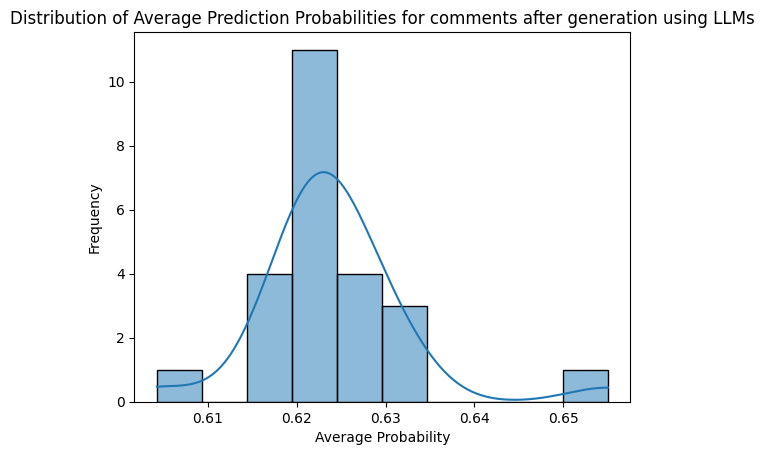

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming `results_df` is your DataFrame
sns.histplot(data=results_df, x='avg_prob_gen_comment', bins=10, kde=True)
plt.title('Distribution of Average Prediction Probabilities for comments after generation using LLMs')
plt.xlabel('Average Probability')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd

# Load the DataFrame if not already loaded
# results_df = pd.read_csv("/path/to/your/analysis_summary.csv")

# Assuming the presence of insights can be determined from the 'csv_file' path naming
results_df['has_insights'] = results_df['csv_file'].apply(lambda x: 'with_insights' in x)


In [ ]:
conversion_comparison = results_df.groupby('has_insights')[['conversion_rate_gen_comment', 'conversion_rate_text']].mean()

print(conversion_comparison)


              conversion_rate_gen_comment  conversion_rate_text
has_insights                                                   
False                                 1.0                  0.96


In [ ]:
prob_diff_comparison = results_df.groupby('has_insights')[['avg_prob_diff', 'median_prob_diff', 'std_prob_diff']].mean()

print(prob_diff_comparison)


              avg_prob_diff  median_prob_diff  std_prob_diff
has_insights                                                
False              0.015661          0.013503       0.026392


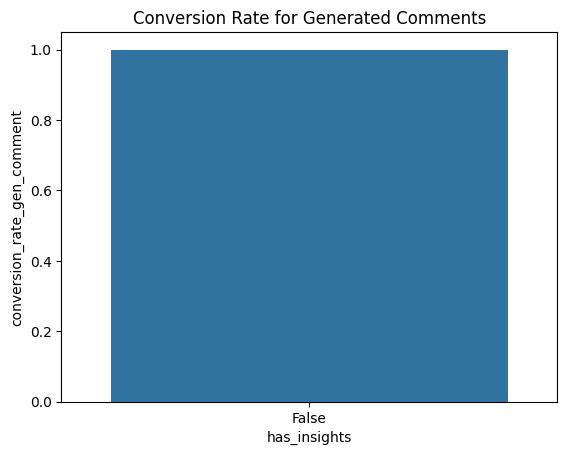

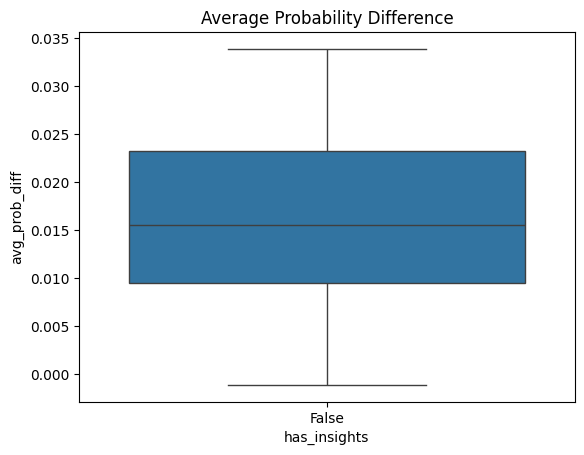

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion Rate Comparison
sns.barplot(x='has_insights', y='conversion_rate_gen_comment', data=results_df)
plt.title('Conversion Rate for Generated Comments')
plt.show()

# Average Probability Difference
sns.boxplot(x='has_insights', y='avg_prob_diff', data=results_df)
plt.title('Average Probability Difference')
plt.show()


In [ ]:
import pandas as pd

# Assuming results_df is your loaded DataFrame with the analysis results
# Add columns for 'model_name' and 'has_insights' based on 'csv_file'
results_df['model_name'] = results_df['csv_file'].apply(lambda x: x.split('/')[-3])  # Adjust according to your path structure
results_df['has_insights'] = results_df['csv_file'].apply(lambda x: 'with_insights' in x)


In [ ]:
# Select only numeric columns for aggregation, excluding non-numeric ones
numeric_cols = ['conversion_rate_gen_comment', 'conversion_rate_text', 'avg_prob_gen_comment', 'avg_prob_text', 'avg_prob_diff']
grouped_metrics = results_df.groupby(['model_name', 'has_insights'])[numeric_cols].mean().reset_index()


In [ ]:
# Ensure 'has_insights' is of a boolean or categorical type if not already
results_df['has_insights'] = results_df['has_insights'].astype('bool')  # Or 'category', based on your preference


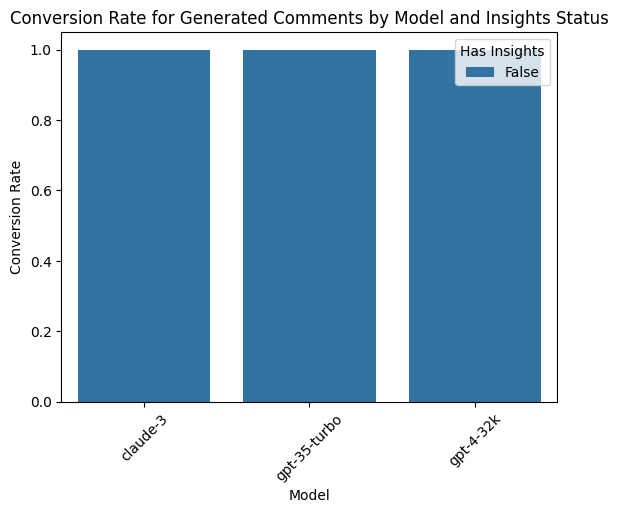

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='model_name', y='conversion_rate_gen_comment', hue='has_insights', data=grouped_metrics)
plt.title('Conversion Rate for Generated Comments by Model and Insights Status')
plt.ylabel('Conversion Rate')
plt.xlabel('Model')
plt.legend(title='Has Insights')
plt.xticks(rotation=45)
plt.show()


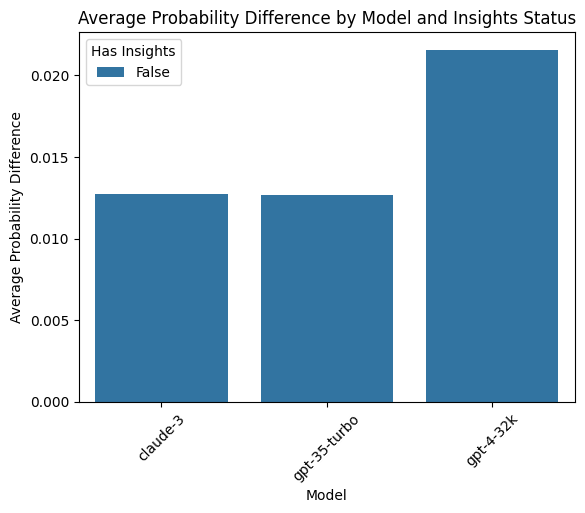

In [ ]:
sns.barplot(x='model_name', y='avg_prob_diff', hue='has_insights', data=grouped_metrics)
plt.title('Average Probability Difference by Model and Insights Status')
plt.ylabel('Average Probability Difference')
plt.xlabel('Model')
plt.legend(title='Has Insights')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import pandas as pd
import os
import re

def extract_details_from_path(path):
    parts = path.split('/')
    model_name = parts[-3]
    insights_status = parts[-2]
    match = re.match(r'test_(.*?)_results\.csv', parts[-1])
    if match:
        data_trained_on = match.group(1)
    else:
        data_trained_on = 'Unknown'  # Use a placeholder or handle this case as needed
    
    return model_name, insights_status, 'with_insights' if 'with' in insights_status else 'no_insights', data_trained_on


# Assuming results_df is your DataFrame containing the csv_file column
results_df[['model_name', 'insights_status', 'insights_binary', 'data_trained_on']] = results_df.apply(lambda x: extract_details_from_path(x['csv_file']), axis=1, result_type='expand')


In [ ]:
grouped_analysis = results_df.groupby(['model_name', 'insights_status', 'data_trained_on'])['avg_prob_diff'].mean().reset_index()

# To compare across models
model_comparison = grouped_analysis.pivot(index='model_name', columns='data_trained_on', values='avg_prob_diff')
print("Model Comparison:\n", model_comparison)

# To compare with and without insights for each model
insights_comparison = grouped_analysis.pivot(index=['model_name', 'insights_status'], columns='data_trained_on', values='avg_prob_diff')
print("\nInsights Comparison:\n", insights_comparison)

# To compare based on the data trained on
data_comparison = grouped_analysis.pivot(index='data_trained_on', columns='model_name', values='avg_prob_diff')
print("\nData Trained On Comparison:\n", data_comparison)


ValueError: Index contains duplicate entries, cannot reshape

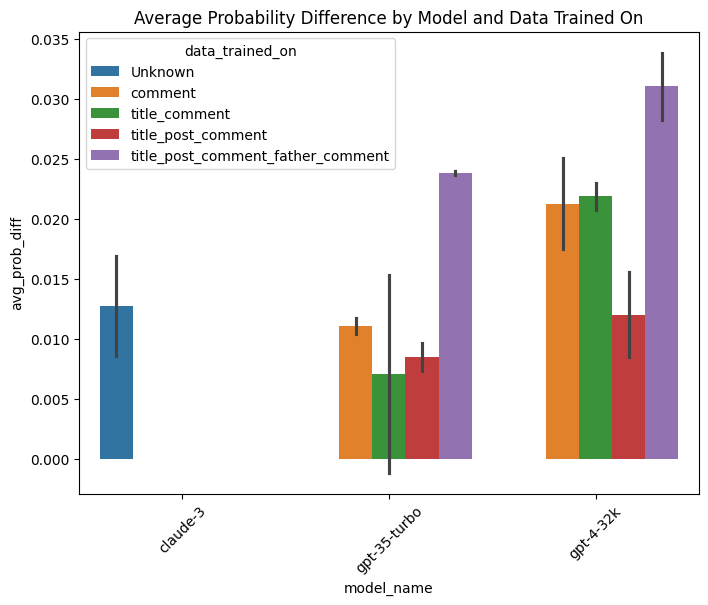

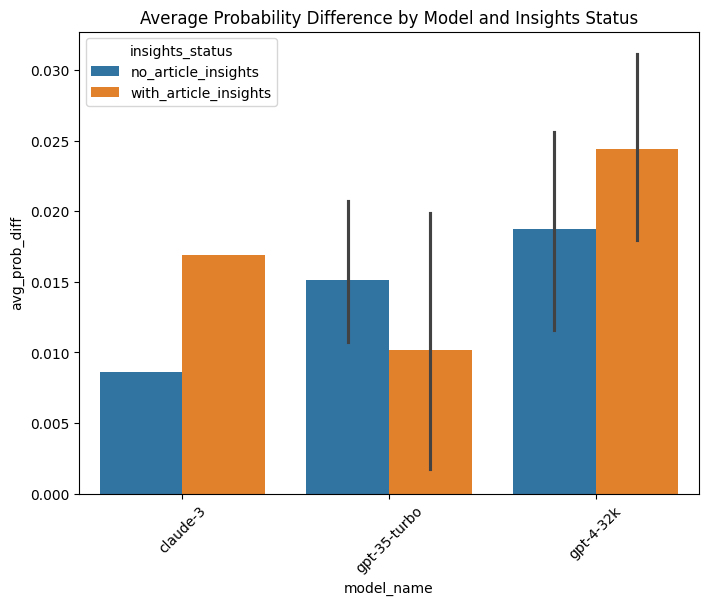

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization for model comparison
plt.figure(figsize=(8, 6))
sns.barplot(x='model_name', y='avg_prob_diff', hue='data_trained_on', data=grouped_analysis)
plt.title('Average Probability Difference by Model and Data Trained On')
plt.xticks(rotation=45)
plt.show()

# Visualization for insights comparison
plt.figure(figsize=(8, 6))
sns.barplot(x='model_name', y='avg_prob_diff', hue='insights_status', data=grouped_analysis)
plt.title('Average Probability Difference by Model and Insights Status')
plt.xticks(rotation=45)
plt.show()


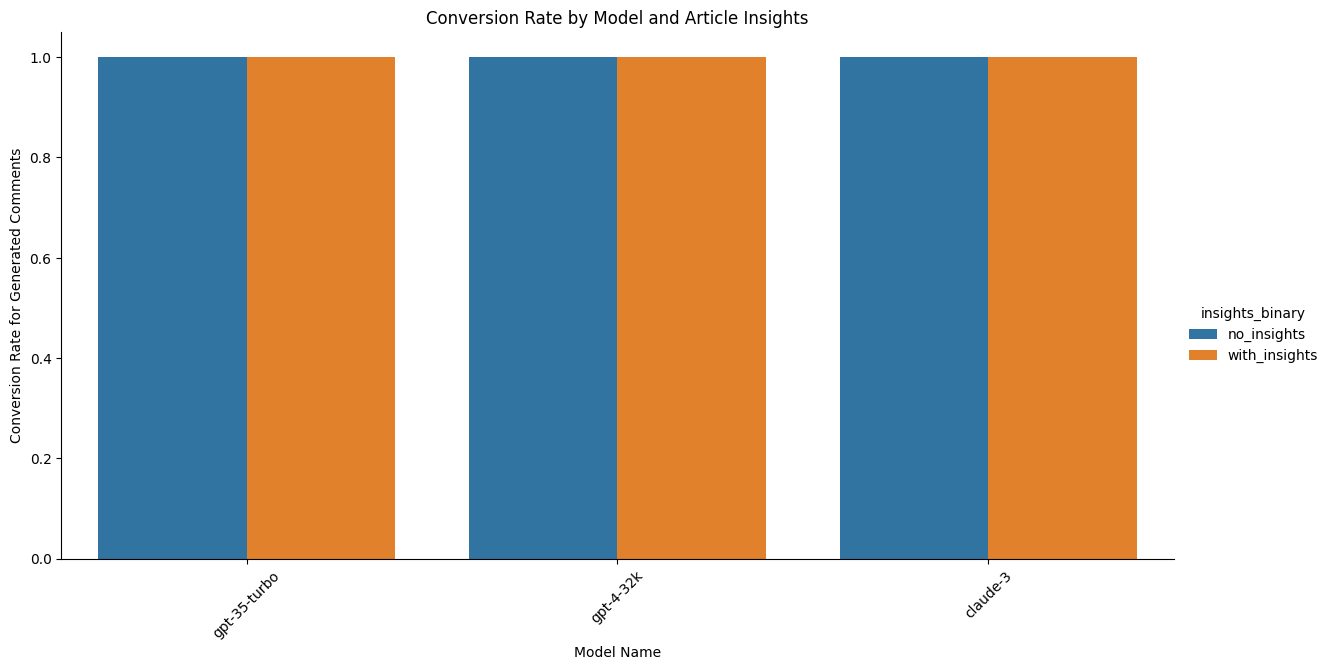

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(x='model_name', y='conversion_rate_gen_comment', hue='insights_binary', kind='bar', data=results_df, height=6, aspect=2)
plt.title('Conversion Rate by Model and Article Insights')
plt.ylabel('Conversion Rate for Generated Comments')
plt.xlabel('Model Name')
plt.xticks(rotation=45)
plt.show()


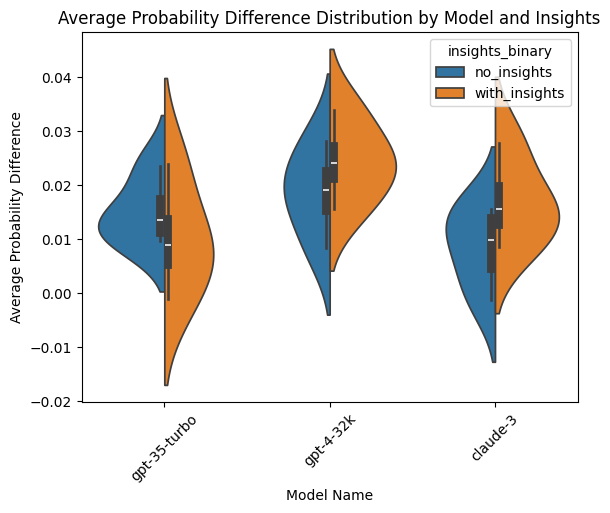

In [ ]:
sns.violinplot(x='model_name', y='avg_prob_diff', hue='insights_binary', data=results_df, split=True)
plt.title('Average Probability Difference Distribution by Model and Insights')
plt.xlabel('Model Name')
plt.ylabel('Average Probability Difference')
plt.xticks(rotation=45)
plt.show()


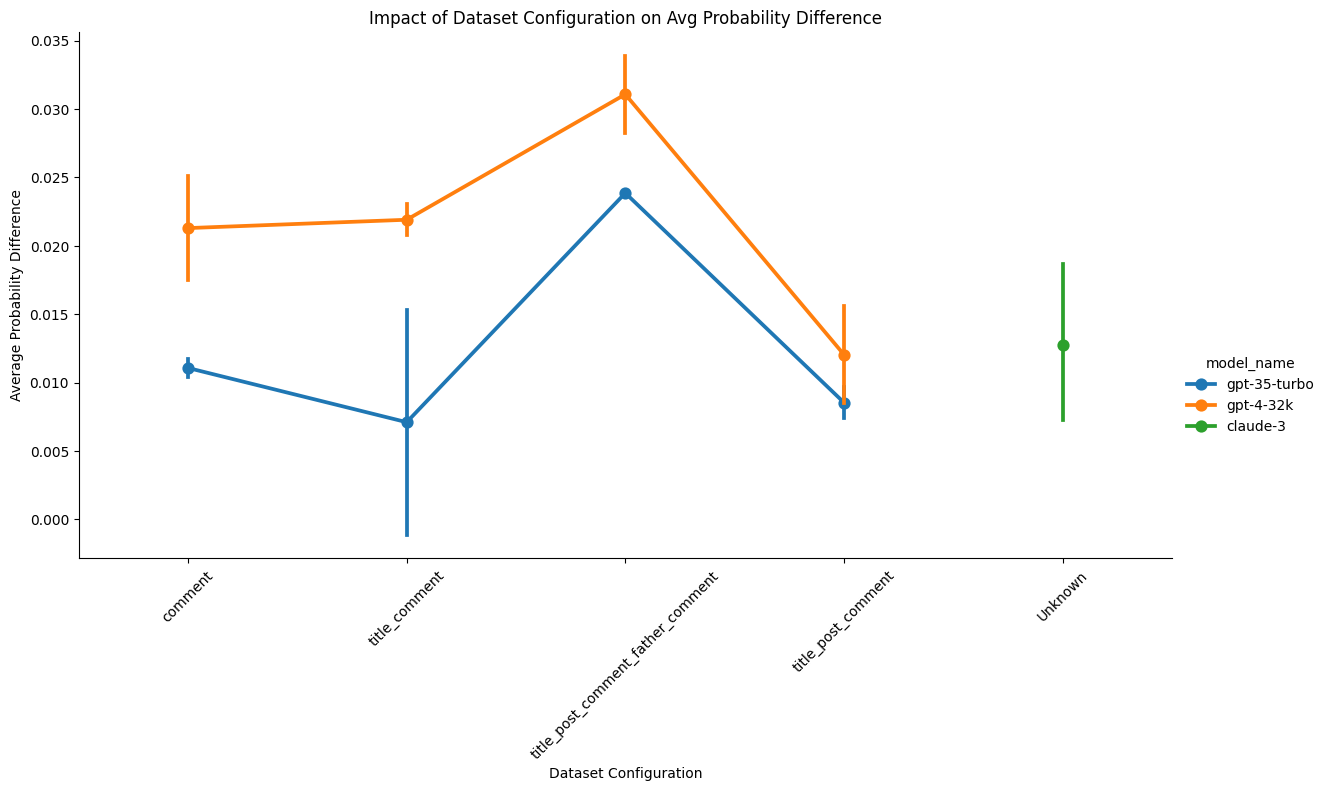

In [ ]:
sns.catplot(x='data_trained_on', y='avg_prob_diff', hue='model_name', kind='point', data=results_df, height=6, aspect=2)
plt.title('Impact of Dataset Configuration on Avg Probability Difference')
plt.xlabel('Dataset Configuration')
plt.ylabel('Average Probability Difference')
plt.xticks(rotation=45)
plt.show()


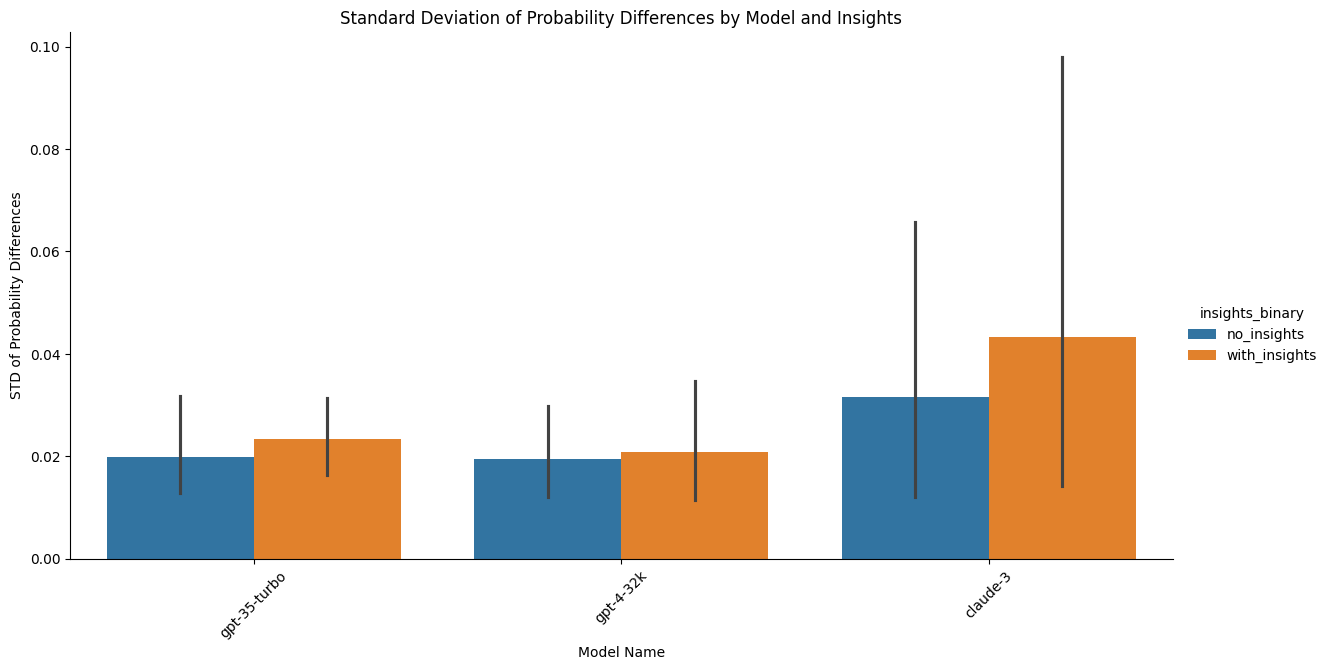

In [ ]:
sns.catplot(x='model_name', y='std_prob_diff', hue='insights_binary', kind='bar', data=results_df, height=6, aspect=2)
plt.title('Standard Deviation of Probability Differences by Model and Insights')
plt.xlabel('Model Name')
plt.ylabel('STD of Probability Differences')
plt.xticks(rotation=45)
plt.show()


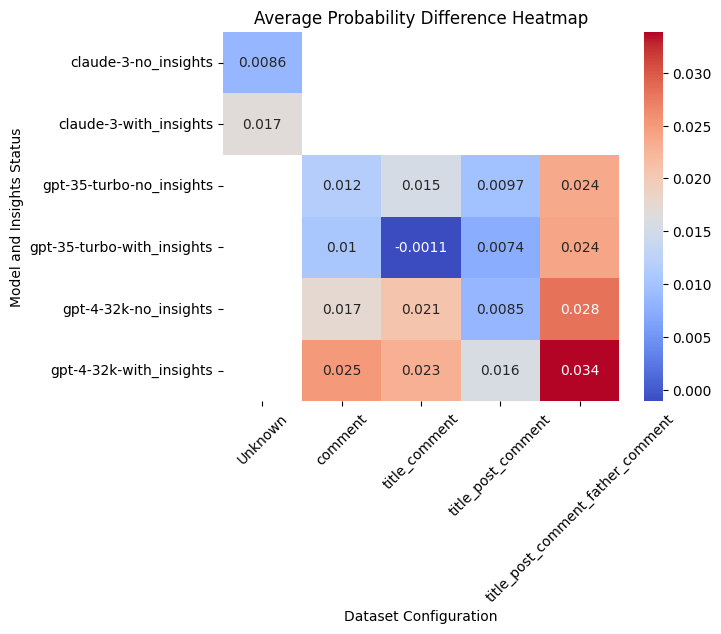

In [ ]:
# Prepare a wide-form DataFrame suitable for sns.heatmap()
heatmap_data = results_df.pivot_table(index=['model_name', 'insights_binary'], columns='data_trained_on', values='avg_prob_diff')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Average Probability Difference Heatmap')
plt.xlabel('Dataset Configuration')
plt.ylabel('Model and Insights Status')
plt.xticks(rotation=45)
plt.show()


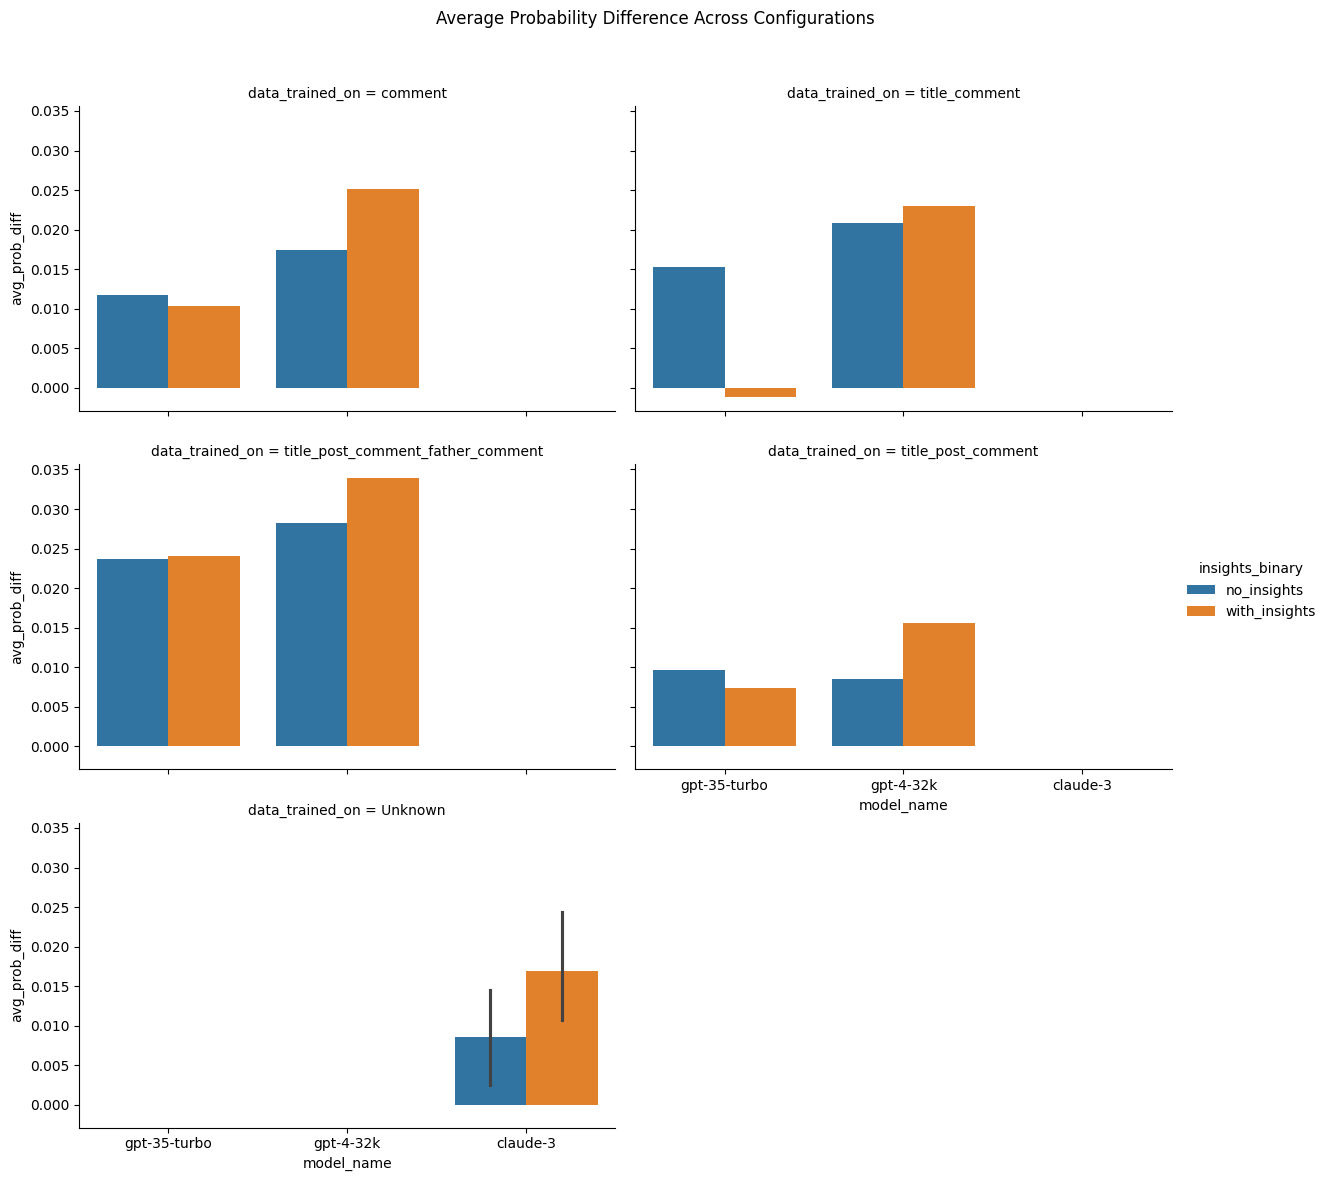

In [ ]:
sns.catplot(x='model_name', y='avg_prob_diff', hue='insights_binary', col='data_trained_on', kind='bar', data=results_df, col_wrap=2, height=4, aspect=1.5)
plt.subplots_adjust(top=0.9)
plt.suptitle('Average Probability Difference Across Configurations')
plt.show()
